In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from scipy import signal
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.io as sio

In [49]:
global GROUND_TRUTH
global NUM_CLASSES
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

### Load the dataset

In [50]:
data = sio.loadmat('Salinas_corrected.mat') # this is a dictionary
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])


In [51]:
hsi_image = data['salinas_corrected']
gt = sio.loadmat('Salinas_gt.mat')['salinas_gt']


In [52]:
print(hsi_image.shape)

(512, 217, 204)


## Display ground truth

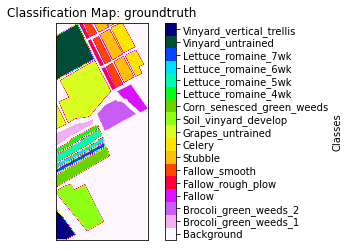

In [53]:
def display_class(data, title=''):
    # this function is from "LEt_SNE_ICASSP2020.ipynb" in "https://github.com/meghshukla/LEt-SNE"
    '''
    NUMPY
    Displays Classification Map
    :param data: 2D Numpy array containing pixel wise labels
    :return: None
    '''
    fig, ax = plt.subplots()

    plt.imshow(data, cmap=plt.cm.get_cmap('gist_ncar_r', NUM_CLASSES + 1))
    plt.title('Classification Map: ' + title)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
    cbar.set_ticks(np.arange(NUM_CLASSES + 1))
    cbar.set_ticklabels(GROUND_TRUTH)

    return None
display_class(gt, 'groundtruth')


### Plot the curve of one sample

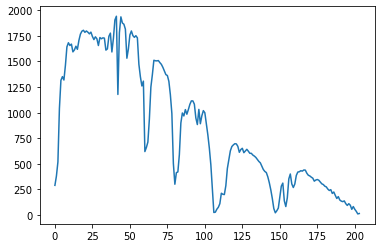

In [54]:
# get any position 
pos = [0,1]
feature = hsi_image[pos[0],pos[1],:]
plt.plot(feature)

## Data Prepossessing

#### Remark: The commented code is a test on our identified limitation:  Adding a Gaussian Blurring

In [55]:
# from skimage.filters import gaussian
# hsi_image = gaussian(hsi_image, sigma=5, channel_axis=True)

### 1. Reshape the 3-D image dataset into a 2-D structural data

In [56]:
data_2d = hsi_image.reshape(hsi_image.shape[0]*hsi_image.shape[1],hsi_image.shape[2])
y_gt = gt.ravel() # convert the 2d groundtruth into a vector

In [57]:
print(data_2d.shape)

(111104, 204)


In [58]:
y_gt.shape

(111104,)

### 2. Dataset Standardization

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(data_2d)

### 3. Remove the samples labeled with 0

In [60]:
X = np.delete(data_2d, np.where(y_gt == 0), axis = 0)
y = np.delete(y_gt, np.where(y_gt == 0))

In [61]:
print(X.shape)
print(y.shape)

(54129, 204)
(54129,)


In [62]:
##PCA

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
data_new_2d = pca.fit_transform(X)

In [64]:
data_new_2d.shape

(54129, 5)

## Split into training & test set

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data_new_2d, y, test_size = 0.2, random_state=88)

print('X_train = ', X_train.shape)
print('X_test = ', X_test.shape)
print('y_train = ', y_train.shape)
print('y_test = ', y_test.shape)

X_train =  (43303, 5)
X_test =  (10826, 5)
y_train =  (43303,)
y_test =  (10826,)


## KNN Classifier

In [83]:
knn=KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [88]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn,X_train,y_train,cv=5,n_jobs=4)
print('Mean cross validation score: ', scores.mean())

Mean cross validation score:  0.9079972470896986


In [89]:
y_pred = knn.predict(X_test)

In [90]:
print('Accuracy: ', knn.score(X_test, y_test))

Accuracy:  0.905597635322372


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99       386
           2       0.99      1.00      0.99       749
           3       0.95      1.00      0.97       385
           4       0.99      1.00      1.00       283
           5       0.99      0.98      0.98       521
           6       1.00      1.00      1.00       778
           7       1.00      0.99      0.99       724
           8       0.79      0.82      0.80      2271
           9       0.98      1.00      0.99      1259
          10       0.92      0.91      0.91       665
          11       0.96      0.98      0.97       245
          12       0.98      1.00      0.99       391
          13       0.98      0.97      0.97       166
          14       0.96      0.97      0.96       215
          15       0.71      0.65      0.68      1423
          16       0.99      0.98      0.98       365

    accuracy                           0.91     10826
   macro avg       0.95   

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from matplotlib.colors import LogNorm
def plot_confusion_matrix(labels, preds, class_names, title='KNN Confusion matrix', log=False):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py"
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale

    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('bottom')
    if log:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()


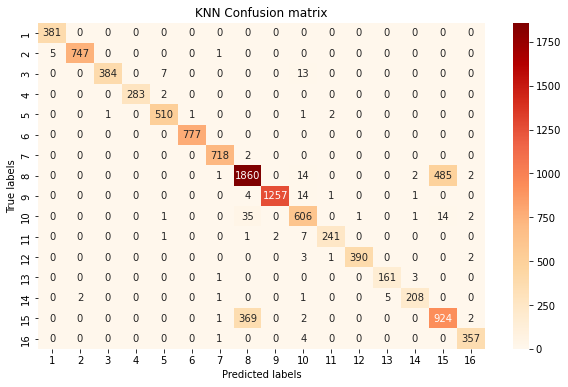

In [72]:
plot_confusion_matrix(y_pred, y_test, class_names=np.arange(1,17).astype(str), log=False)

In [74]:
def plot_histogram_compare_predict_expect(predict, true):
    '''
    Plot histogram and compare to predictions histogram
    params
    ----------
    predict: Predictions array of shape (n_samples,)
    expect: Expectations array of shape (n_samples,)
    title: Matplotlib title
    '''
    fig, axs = plt.subplots(figsize=(20, 6))

    bar_x, bar_count_pred = np.unique(predict, return_counts=True)
    bar1 = axs.bar(bar_x - 0.2, bar_count_pred, 0.4, label="Predicted")

    bar_x, bar_count_exp = np.unique(true, return_counts=True)
    bar2 = axs.bar(bar_x + 0.2, bar_count_exp, 0.4, label="True")

    axs.bar_label(bar1, padding=3)
    axs.bar_label(bar2, padding=3)

    axs.set_xticks(np.arange(1,len(bar_x)+1))
    axs.set_xticklabels(bar_x)

    axs.set_title('Number of Predicted and True Labels', fontdict={'size':17})
    axs.legend()
    plt.show()

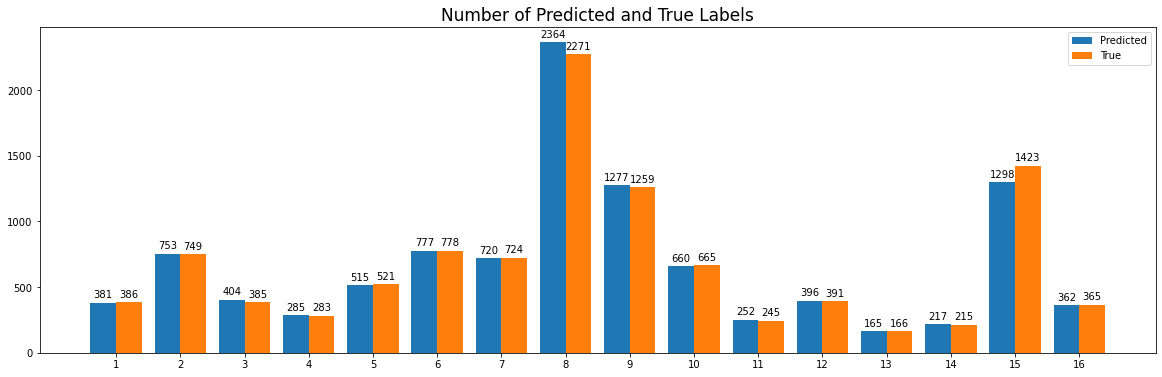

In [75]:
plot_histogram_compare_predict_expect(y_pred,y_test)

### Plot the error rate with different K values 

In [76]:
error = []
accuracy=[]

# Calculating error for K values between 1 and 40
for i in range(2, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

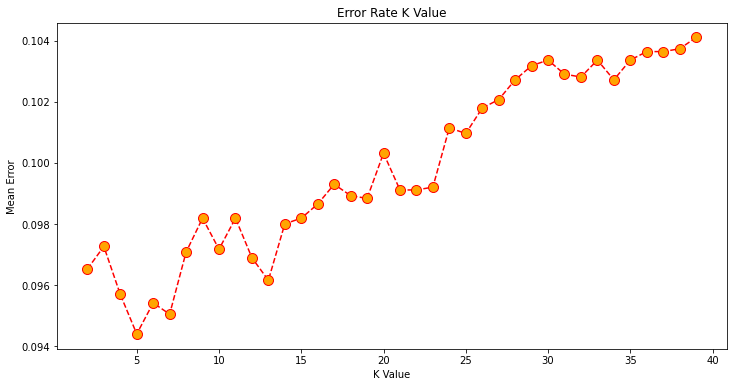

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='orange', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [82]:
preds_salinas = knn.predict(data_new_2d)
print(preds_salinas.shape)


(54129,)


In [79]:
idx_arr1 = np.argwhere(gt.flatten() != 0).flatten()
salinas_img_pred = np.zeros((gt.shape[0]*gt.shape[1]))
salinas_img_pred[idx_arr1] = preds_salinas

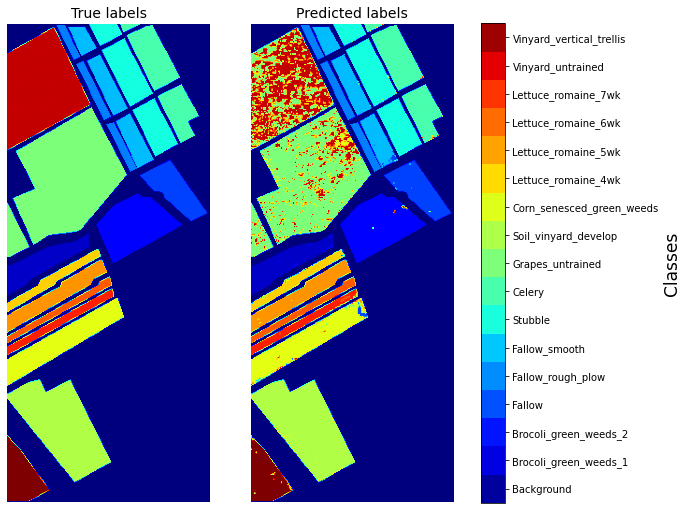

In [80]:
labels = np.dstack((gt,salinas_img_pred.reshape((gt.shape[0], gt.shape[1]))))
titles = ['True labels', 'Predicted labels']
fig, axs = plt.subplots(1, 2, figsize=(10, 14))
for col in range(2):
    ax = axs[col]
    ax.axis('off')
    pcm = ax.imshow(labels[:,:,col], cmap='jet')
    ax.set_title(titles[col],fontdict = {'size':14})
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs.ravel().tolist(), boundaries=(np.arange(NUM_CLASSES + 2) - 0.5),shrink=0.63)
cbar.set_label('Classes', fontdict = {'size':17})
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)